# Testing single vs multilabel models
Alyssa's 11/6

Question: Does single vs multiple labels perform better?

In this file, we first test the SMC3/Rad21/CTCF complex.

We then run all single model TFs on 20,000 iterations.

# Imports

In [ ]:
import collections
import datetime

import pyDNase
import tensorflow as tf
import h5py
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import kipoi
import os
import pybedtools
import torch
import h5sparse
import datetime
import logging

from scipy import stats

from pyDNase import GenomicInterval
from scipy.sparse import coo_matrix, vstack

from scipy.fftpack import fft, ifft

import sys

# Define Paths for this user

In [564]:
########################## PATHS ###########################
# path to where dnase bams are stored. Bams need to be sorted and indexed. See bin/download_dnase_encode.sh for
# data processing
_ENCODE_DATA_PREFIX =  "/data/akmorrow/encode_data/"

deepsea_path = "/data/akmorrow/epitome_data/deepsea_train/"
dnase_preprocessed_path = "/data/akmorrow/epitome_data/processed_dnase/"
feature_path = "/home/eecs/akmorrow/epitome/data/feature_name"

_DEEPSEA_GENOME_REGIONS_FILENAME = "/home/eecs/akmorrow/epitome/data/allTFs.pos.bed"

# DNase filepath dictionary
prefix_ =  "/data/akmorrow/encode_data/"

# get TF logger
log = logging.getLogger('tensorflow')
tf_log = "/home/eecs/akmorrow/epitome/dnase/tensorflow_combination.log"
fh = logging.FileHandler(tf_log)
fh.setLevel(logging.INFO)
log.addHandler(fh)

In [565]:
exec(open("./constants.py").read())
exec(open("./functions.py").read())
exec(open("./generators.py").read())
exec(open("./models.py").read())

# Load Data

### Load DeepSEA data

In [ ]:
train_data, valid_data, test_data = load_deepsea_data(deepsea_path)


In [ ]:
print(valid_data["x"].shape, train_data["x"].shape, test_data["x"].shape)
print(valid_data["y"].shape, train_data["y"].shape, test_data["y"].shape)

# Choose cell types and assays

Here, we choose SMC3, CTCF, and Rad21, a well known complex that is correlated.

# Model definition

# Run on  all 3 TFs

['DNase', 'Rad21', 'CTCF', 'SMC3']

In [577]:
# Available cell types
validation_celltypes = ["K562"] # we remove hepg2 from the validation, as there are so few SMC3 cell types to begin with 
test_celltypes = ["HepG2"]


## How well did we perform on A549 using all 3 TFs?

['SK-N-SH_RA', 'K562', 'HepG2', 'HeLa-S3', 'H1-hESC', 'GM12878', 'A549'] ['DNase', 'SMC3', 'Rad21', 'CTCF']


{'DNase': 0, 'SMC3': 1, 'Rad21': 2, 'CTCF': 3}

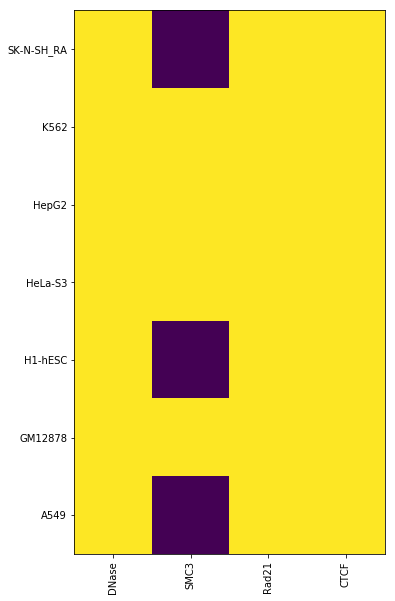

In [578]:
matrix, cellmap, assaymap = get_assays_from_feature_file(feature_path='../data/feature_name', eligible_assays = ["SMC3", "CTCF", "Rad21"], 
                                 eligible_cells = ['K562', 'HepG2', 'HeLa-S3', 'GM12878', 'SK-N-SH_RA', 'H1-hESC', 'A549'])
        
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.xticks(np.arange(len(assaymap)), rotation = 90)
ax.set_xticklabels(assaymap.keys())
plt.yticks(np.arange(len(cellmap)))
ax.set_yticklabels(cellmap.keys())

plt.imshow(matrix!=-1)
print(list(cellmap.keys()), list(assaymap.keys()))


label_assays = list(assaymap)
assaymap

In [581]:
model = MLP(4, [100, 100, 100, 50], 
            tf.tanh, 
            train_data, 
            valid_data, 
            test_data, 
            validation_celltypes,
            test_celltypes,
            gen_from_peaks, 
            matrix,
            assaymap,
            cellmap,
            shuffle_size=2, 
            label_assays = label_assays,
            radii=[1,3,10,30])
model.train(1000)


INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Initializing variables
INFO:tensorflow:Starting Training
INFO:tensorflow:1000 0.31278458
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.9725170433858183
INFO:tensorflow:Our micro AUC:     0.9746335504682421
2018-12-06 15:40:43.503799 0 DNase
INFO:tensorflow:2018-12-06 15:40:43.503910: 0, DNase, NaN
INFO:tensorflow:2018-12-06 15:40:43.506542: 1, SMC3, 0.985780
INFO:tensorflow:2018-12-06 15:40:43.576892: 2, Rad21, 0.994834
INFO:tensorflow:2018-12-06 15:40:43.645253: 3, CTCF, 0.936937
INFO:tensorflow:


In [582]:
test_DNase = model.test(455024, mode = Dataset.TEST, log=True)


# INFO:tensorflow:2018-12-05 12:19:02.977124: 0, DNase, NaN
# INFO:tensorflow:2018-12-05 12:19:02.979063: 1, Rad21, 0.936362
# INFO:tensorflow:2018-12-05 12:19:03.135981: 2, CTCF, 0.972709
# INFO:tensorflow:2018-12-05 12:19:03.300613: 3, SMC3, 0.905783

INFO:tensorflow:Our macro AUC:     0.9707508648122097
INFO:tensorflow:Our micro AUC:     0.9584795131042707
2018-12-06 15:51:16.573500 0 DNase
INFO:tensorflow:2018-12-06 15:51:16.573606: 0, DNase, NaN
INFO:tensorflow:2018-12-06 15:51:16.577058: 1, SMC3, 0.962415
INFO:tensorflow:2018-12-06 15:51:17.056995: 2, Rad21, 0.977929
INFO:tensorflow:2018-12-06 15:51:17.540060: 3, CTCF, 0.971908


# Running just SMC3, Rad21, and CTCF

In [535]:
exec(open("./functions.py").read())
exec(open("./generators.py").read())
time = datetime.datetime.now().time().strftime("%Y-%m-%d_%H:%M:%S")

file = open('/data/akmorrow/epitome_data/out/tmp_prediction_aucs_SMC3Complex_%s.py' % time, 'w')

for assay in ["Rad21", "CTCF", "SMC3"]:
    file.write('%s\n' % (assay))
    file.flush()
    print(" Running on assay %s..." % assay)

    label_assays = ['DNase', assay]
    
    print(assaymap)
    
    model = MLP(4, [100, 100, 100, 50], 
            tf.tanh, 
            train_data, 
            valid_data, 
            test_data, 
            validation_celltypes,
            test_celltypes,
            gen_from_peaks, 
            matrix,
            assaymap,
            cellmap,
            shuffle_size=2, 
            label_assays = label_assays,
            radii=[1,3,10,30])
    model.train(5000)

    test_DNase = model.test(455024, mode = Dataset.TEST, log=True)
    
    # calculate AUC
    macroAUC = test_DNase[2]
    
    # save to file
    file.write('%s, %f \n' % (factor, macroAUC))
    file.flush()
    
file.close()

 Running on assay Rad21...
{'DNase': 0, 'SMC3': 1, 'Rad21': 2, 'CTCF': 3}
INFO:tensorflow:Scale of 0 disables regularizer.


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Initializing variables
INFO:tensorflow:Starting Training
INFO:tensorflow:1000 0.0067012496
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.9951110951981504
INFO:tensorflow:Our micro AUC:     0.9951110951981504
INFO:tensorflow:2018-12-05 16:46:15.773566: 0, DNase, NaN
INFO:tensorflow:2018-12-05 16:46:15.776960: 1, Rad21, 0.995111
INFO:tensorflow:
INFO:tensorflow:2000 0.039937958
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.9958745485905723
INFO:tensorflow:Our micro AUC:     0.9958745485905723
INFO:tensorflow:2018-12-05 16:47:06.189888: 0, DNase, NaN
INFO:tensorflow:2018-12-05 16:47:06.193176: 1, Rad21, 0.995875
INFO:tensorflow:
INFO:tensorflow:3000 0.018227179
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.9935583282506766
INFO:tensorflow:Our micro AUC:     0.9935583282506766
INFO:tensorflow:2018-12-05 16:47:56.598318: 0, DNase, NaN
INFO:tensorflow:2018-12-05 16:47:56.602105: 1, Rad21, 0.993558
INFO:tensorflow:

/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Initializing variables
INFO:tensorflow:Starting Training
INFO:tensorflow:1000 0.37328783
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.9392404032823705
INFO:tensorflow:Our micro AUC:     0.9392404032823705
INFO:tensorflow:2018-12-05 16:54:05.885135: 0, DNase, NaN
INFO:tensorflow:2018-12-05 16:54:05.889366: 1, CTCF, 0.939240
INFO:tensorflow:
INFO:tensorflow:2000 0.29530415
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.9435963500510448
INFO:tensorflow:Our micro AUC:     0.9435963500510448
INFO:tensorflow:2018-12-05 16:54:56.158085: 0, DNase, NaN
INFO:tensorflow:2018-12-05 16:54:56.161715: 1, CTCF, 0.943596
INFO:tensorflow:
INFO:tensorflow:3000 0.5012203
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.9706486745257615
INFO:tensorflow:Our micro AUC:     0.9706486745257615
INFO:tensorflow:2018-12-05 16:55:46.332305: 0, DNase, NaN
INFO:tensorflow:2018-12-05 16:55:46.335819: 1, CTCF, 0.970649
INFO:tensorflow:
INFO:te

/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Initializing variables
INFO:tensorflow:Starting Training
INFO:tensorflow:1000 0.40475821
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.9850475952467446
INFO:tensorflow:Our micro AUC:     0.9850475952467446
INFO:tensorflow:2018-12-05 17:01:54.528784: 0, DNase, NaN
INFO:tensorflow:2018-12-05 17:01:54.532171: 1, SMC3, 0.985048
INFO:tensorflow:
INFO:tensorflow:2000 0.21096352
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.9776161349179512
INFO:tensorflow:Our micro AUC:     0.9776161349179512
INFO:tensorflow:2018-12-05 17:02:44.933639: 0, DNase, NaN
INFO:tensorflow:2018-12-05 17:02:44.936434: 1, SMC3, 0.977616
INFO:tensorflow:
INFO:tensorflow:3000 0.82550275
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.9892786252786806
INFO:tensorflow:Our micro AUC:     0.9892786252786806
INFO:tensorflow:2018-12-05 17:03:35.371771: 0, DNase, NaN
INFO:tensorflow:2018-12-05 17:03:35.375115: 1, SMC3, 0.989279
INFO:tensorflow:
INFO:t

############## END TRIO EXPERIMENTS ##############

# Running on the original data for all TFs separately

In [554]:
# what are the factors and cell types 
factors = DEFAULT_ASSAYS.copy()
cell_types = DEFAULT_CELLS
cell_types
factors.remove("DNase")
print(factors)

matrix, cellmap, assaymap = get_assays_from_feature_file(feature_path='../data/feature_name', eligible_assays = DEFAULT_ASSAYS, 
                                 eligible_cells = DEFAULT_CELLS)

factors = [ 'Rad21', 'Max', 'NRSF', 'GABP',  'CEBPB',  'ZBTB33',  'USF-1']

['CTCF', 'Pol2', 'YY1', 'p300', 'TAF1', 'Pol2-4H8', 'c-Myc', 'Rad21', 'Max', 'NRSF', 'GABP', 'EZH2', 'CEBPB', 'c-Jun', 'ZBTB33', 'USF2', 'USF-1', 'TBP', 'RFX5']


In [ ]:
exec(open("./functions.py").read())
time = datetime.datetime.now().time().strftime("%Y-%m-%d_%H:%M:%S")

file = open('/data/akmorrow/epitome_data/out/tmp_prediction_aucs_%s.py' % time, 'w')

# iterate threw all factors
for factor in factors:
    file.write('%s\n' % (factor))
    file.flush()

    # Available cell types
    validation_celltypes = ["K562", "HepG2"] 
    test_celltypes = ["A549"]

    label_assays = ['DNase', factor]
    
    model = MLP(4, [100, 100, 100, 50], 
            tf.tanh, 
            train_data, 
            valid_data, 
            test_data, 
            validation_celltypes,
            test_celltypes,
            gen_from_peaks, 
            matrix,
            assaymap,
            cellmap,
            shuffle_size=2, 
            label_assays = label_assays,
            radii=[1,3,10,30])
    
    model.train(20000)

    test_DNase = model.test(455024, mode = Dataset.TEST, log=True)
    
    # calculate AUC
    macroAUC = test_DNase[2]
    print(macroAUC)
    
    # save to file
    file.write('%s, %f \n' % (factor, macroAUC))
    file.flush()

file.close()

INFO:tensorflow:Scale of 0 disables regularizer.


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Initializing variables
INFO:tensorflow:Starting Training
INFO:tensorflow:1000 0.050159894
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.9827019428025823
INFO:tensorflow:Our micro AUC:     0.9827019428025823
INFO:tensorflow:2018-12-06 10:17:35.658603: 0, DNase, NaN
INFO:tensorflow:2018-12-06 10:17:35.660986: 1, Rad21, 0.982702
INFO:tensorflow:
INFO:tensorflow:2000 0.087634
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.9841711223763984
INFO:tensorflow:Our micro AUC:     0.9841711223763984
INFO:tensorflow:2018-12-06 10:18:27.550226: 0, DNase, NaN
INFO:tensorflow:2018-12-06 10:18:27.553016: 1, Rad21, 0.984171
INFO:tensorflow:
INFO:tensorflow:3000 0.11033255
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.9862237776706921
INFO:tensorflow:Our micro AUC:     0.9862237776706921
INFO:tensorflow:2018-12-06 10:19:19.491583: 0, DNase, NaN
INFO:tensorflow:2018-12-06 10:19:19.494607: 1, Rad21, 0.986224
INFO:tensorflow:
INFO

/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Initializing variables
INFO:tensorflow:Starting Training
INFO:tensorflow:1000 1.9919062
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.899484870842046
INFO:tensorflow:Our micro AUC:     0.899484870842046
INFO:tensorflow:2018-12-06 10:39:05.348499: 0, DNase, NaN
INFO:tensorflow:2018-12-06 10:39:05.351798: 1, Max, 0.899485
INFO:tensorflow:
INFO:tensorflow:2000 0.23386818
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.9077567957869391
INFO:tensorflow:Our micro AUC:     0.9077567957869391
INFO:tensorflow:2018-12-06 10:39:57.181675: 0, DNase, NaN
INFO:tensorflow:2018-12-06 10:39:57.184471: 1, Max, 0.907757
INFO:tensorflow:
INFO:tensorflow:3000 0.097791314
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.9178232074121081
INFO:tensorflow:Our micro AUC:     0.9178232074121081
INFO:tensorflow:2018-12-06 10:40:48.994350: 0, DNase, NaN
INFO:tensorflow:2018-12-06 10:40:48.997094: 1, Max, 0.917823
INFO:tensorflow:
INFO:tensor

/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Initializing variables
INFO:tensorflow:Starting Training
INFO:tensorflow:1000 1.2752923
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.934330219462654
INFO:tensorflow:Our micro AUC:     0.934330219462654
INFO:tensorflow:2018-12-06 11:00:08.528533: 0, DNase, NaN
INFO:tensorflow:2018-12-06 11:00:08.531913: 1, NRSF, 0.934330
INFO:tensorflow:
INFO:tensorflow:2000 1.9155204
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.921611351888539
INFO:tensorflow:Our micro AUC:     0.921611351888539
INFO:tensorflow:2018-12-06 11:01:00.373513: 0, DNase, NaN
INFO:tensorflow:2018-12-06 11:01:00.376321: 1, NRSF, 0.921611
INFO:tensorflow:
INFO:tensorflow:3000 0.048393734
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.9449233110728861
INFO:tensorflow:Our micro AUC:     0.9449233110728861
INFO:tensorflow:2018-12-06 11:01:52.329206: 0, DNase, NaN
INFO:tensorflow:2018-12-06 11:01:52.332513: 1, NRSF, 0.944923
INFO:tensorflow:
INFO:tensor

/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Initializing variables
INFO:tensorflow:Starting Training
INFO:tensorflow:1000 0.5288604
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.9110488444027889
INFO:tensorflow:Our micro AUC:     0.9110488444027889
INFO:tensorflow:2018-12-06 11:21:21.984311: 0, DNase, NaN
INFO:tensorflow:2018-12-06 11:21:21.987132: 1, GABP, 0.911049
INFO:tensorflow:
INFO:tensorflow:2000 0.4282516
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.91852511220785
INFO:tensorflow:Our micro AUC:     0.91852511220785
INFO:tensorflow:2018-12-06 11:22:13.807994: 0, DNase, NaN
INFO:tensorflow:2018-12-06 11:22:13.810848: 1, GABP, 0.918525
INFO:tensorflow:
INFO:tensorflow:3000 0.011720598
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.9491717264681947
INFO:tensorflow:Our micro AUC:     0.9491717264681947
INFO:tensorflow:2018-12-06 11:23:05.911514: 0, DNase, NaN
INFO:tensorflow:2018-12-06 11:23:05.914328: 1, GABP, 0.949172
INFO:tensorflow:
INFO:tensor

/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Initializing variables
INFO:tensorflow:Starting Training
INFO:tensorflow:1000 0.5128212
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.758898451897015
INFO:tensorflow:Our micro AUC:     0.758898451897015
INFO:tensorflow:2018-12-06 11:51:00.976778: 0, DNase, NaN
INFO:tensorflow:2018-12-06 11:51:00.979290: 1, CEBPB, 0.758898
INFO:tensorflow:
INFO:tensorflow:2000 0.78320956
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.7687241481390602
INFO:tensorflow:Our micro AUC:     0.7687241481390602
INFO:tensorflow:2018-12-06 11:52:26.070382: 0, DNase, NaN
INFO:tensorflow:2018-12-06 11:52:26.073232: 1, CEBPB, 0.768724
INFO:tensorflow:
INFO:tensorflow:3000 4.033342
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.6949670111364048
INFO:tensorflow:Our micro AUC:     0.6949670111364048
INFO:tensorflow:2018-12-06 11:53:18.020660: 0, DNase, NaN
INFO:tensorflow:2018-12-06 11:53:18.023

/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Initializing variables
INFO:tensorflow:Starting Training
INFO:tensorflow:1000 0.18156277
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.8524764411027568
INFO:tensorflow:Our micro AUC:     0.8524764411027568
INFO:tensorflow:2018-12-06 12:17:18.587529: 0, DNase, NaN
INFO:tensorflow:2018-12-06 12:17:18.590345: 1, ZBTB33, 0.852476
INFO:tensorflow:
INFO:tensorflow:2000 0.05303548
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.8968384122818008
INFO:tensorflow:Our micro AUC:     0.8968384122818008
INFO:tensorflow:2018-12-06 12:18:10.369701: 0, DNase, NaN
INFO:tensorflow:2018-12-06 12:18:10.372585: 1, ZBTB33, 0.896838
INFO:tensorflow:
INFO:tensorflow:3000 0.012074836
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.9386421093051182
INFO:tensorflow:Our micro AUC:     0.9386421093051182
INFO:tensorflow:2018-12-06 12:19:02.186110: 0, DNase, NaN
INFO:tensorflow:2018-12-06 12:19:02.189026: 1, ZBTB33, 0.938642
INFO:tensorflow:

In [560]:
# all AUCs
avg = np.array([.876,0.886663 ,0.780607, 0.860361 ,0.911357 ,0.963778 ,0.992678, .972232,0.969579,0.923894,0.909216,0.918032  ])
avg.mean()
